#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 세가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : 사전학습된 Word2Vec 모델을 로딩하여 train의 임베딩벡터 저장
    * 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기
* 챗봇3. 단계별 모델링2
    * 1단계 : 챗봇2의 1단계 모델을 그대로 활용
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇3개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

### (1)라이브러리 설치

#### 1) gensim 3.8.3 설치

In [1]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
# 현재 4.x 버전이 최신이지만, 3.8.3 버전으로 진행
!pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=26528042 sha256=5185035ae75563bf8abb6b45e627172cf721eac0866c014c64975e3458691086
  Stored in directory: /root/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.1
    Uninstalling gensim-4.3.1:
      Successfully uninstalled gensim-4.3.1


* [코랩] 위 라이브러리 설치후 런타임 재시작 필요!

#### 2) 형태소 분석을 위한 라이브러리

In [1]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
curl is already the newest version (7.68.0-1ubuntu2.18).
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.8ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.16.3-1ubuntu1.20.04.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
g++ is already the newest version (4:9.3.0-1ubuntu2).
g++ set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Reading package lists... Done
Buil

In [67]:
# 형태소 기반 토크나이징 (Konlpy)
# !python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Install mecab-ko
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0  1034k      0  0:00:01  0:00:01 --:--:-- 6309k
mecab-0.996-ko-0.9.2/
mecab-0.996-ko-0.9.2/example/
mecab-0.996-ko-0.9.2/example/example.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.cpp
mecab-0.996-ko-0.9.2/example/example_lattice.c
mecab-0.996-ko-0.9.2/example/example.c
mecab-0.996-ko-0.9.2/example/thread_test.cpp
mecab-0.996-ko-0.9.2/mecab-config.in
mecab-0.996-ko-0.9.2/man/
mecab-0.996-ko-0.9.2/man/Makefile.am
mecab-0.996-ko-0.9.2/man/mecab.1
mecab-0.996-ko-0.9.2/man/Makefile.in
mecab-0.996-ko-0.9.2/mecab.iss.in
mecab-0.996-ko-0.9.2/config.guess
mecab-0.996-ko-0.9.2/README
mecab-0.996-ko-0.9.2/COPYING
mecab-0.996-ko-0.9.2/CHANGES.md
mecab-0.996-ko-0.9.2/README.md
mecab-0.996-ko-0.9.2/INSTALL
mecab-0

### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import * 

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from keras import Input, Model
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics.pairwise import cosine_similarity



* 형태소 분석을 위한 함수를 제공합니다.

In [3]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()
        
    return tokenizer

In [4]:
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:       
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)
    
    return tokenized_sent

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions

* 구글 드라이브 연결

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
path = '/content/drive/MyDrive/6_mini/새 폴더/'

* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [7]:
train = joblib.load(path + 'train.pkl') 
test = joblib.load(path + 'test.pkl') 
clean_train_questions = joblib.load(path + 'clean_train_questions.pkl') 
clean_test_questions = joblib.load(path + 'clean_test_questions.pkl') 

In [186]:
train

,intent,Q,A,type
983,43,다른 지역에서도 교육이 가능한가요,"KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...",1
706,34,합격 후 교육 등록신청을 하지 않으면 재지원이 가능한가요,교육 등록신청을 하지 않거나 교육 일정 시작 전에 교육 등록을 취소해도 지원자격에 ...,1
838,39,대학원생 서류가 어떻게 되나요,학교 사정으로 졸업예정증명서 발급이 불가능한 경우 수료증명서 또는 재학증명서를 제출...,1
448,27,재밌는 거 뭐 없나,제가 있잖아요.,0
56,2,생각보다 오늘 너무 춥네,감기 조심하세요.,0
...,...,...,...,...
858,39,미국 대학의 경우 증빙서류가 무엇인가요,학교 사정으로 졸업예정증명서 발급이 불가능한 경우 수료증명서 또는 재학증명서를 제출...,1
1089,46,참가시 제공되는 노트북이 있나요,"교육기간 동안 노트북을 무료로 지원하며, 교육에 필요한 필수 프로그램이 설치되어 있...",1
521,31,대학교 졸업 예정인데 지원할 수 있나요,KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업...,1
648,32,군복무자가 교육을 받으려면 별도의 신청 절차가 필요한가요,"KT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시작일 기준 재직자는 지원이 불가...",1


In [32]:
train.shape

(1038, 4)

In [33]:
test.shape

(260, 4)

In [187]:
clean_train_questions.shape

(1038,)

## 2.챗봇1

* 굵은 텍스트 **상세요구사항**
    * Word2Vec을 활용한 LightGBM 모델링(intent 분류)
        * Word2Vec을 이용하여 임베딩벡터 생성하기
            * Word Embedding으로 문장벡터 구하기
        * 임베딩 벡터를 이용하여 ML기반 모델링 수행하기
            * LightGBM 권장(다른 알고리즘을 이용할수 있습니다.)
    * 챗봇 : 모델의 예측결과(intent)에 따라 답변하는 챗봇 만들기
        * 질문을 입력받아, 답변하는 함수 생성

### (1) Word2Vec을 이용하여 임베딩벡터 생성하기
* 'mecab' 형태소 분석기를 이용하여 문장을 tokenize
    * Word2Vec 모델을 만들기 위해서 입력 데이터는 리스트 형태여야 합니다.
    * 그래서 다시 리스트로 저장되도록 토크나이즈 해 봅시다.
* Word Embedding으로 문장벡터를 생성합니다.
    * 먼저 Word2Vec 모델을 만들고, train의 질문들을 문장벡터로 만듭시다.


#### 1) 'mecab' 형태소 분석기를 이용하여 문장을 tokenize

In [8]:
tok = list(clean_train_questions)

In [9]:
tok_ = []
for i in clean_train_questions:
    tok_.append(i.split(" "))
tok_

[['다른', '지역', '에서', '도', '교육', '이', '가능', '한가요'],
 ['합격',
  '후',
  '교육',
  '등록',
  '신청',
  '을',
  '하',
  '지',
  '않',
  '으면',
  '재',
  '지원',
  '이',
  '가능',
  '한가요'],
 ['대학원생', '서류', '가', '어떻게', '되', '나요'],
 ['재밌', '는', '거', '뭐', '없', '나'],
 ['생각', '보다', '오늘', '너무', '춥', '네'],
 ['KT', '채용', '연계', '시', '중점', '적', '으로', '보', '는', '요소', '가', '있', '나요'],
 ['드디어', '천일'],
 ['수업', '외', '에', '시험', '이나', '과제', '가', '있', '나요'],
 ['지원', '자격', '에', '대해서', '알려', '주', '세요'],
 ['미취', '업자', '에', '대한', '기준', '은', '어떻게', '판단', '하', '나요'],
 ['바다', '가', '자', '고', '하', '면', '갈까'],
 ['실업', '급여', '수령', '중', '에', '도', '교육', '을', '들', '을', '수', '있', '나요'],
 ['코', '막혀'],
 ['수업', '만', '들으면', '되', '나요'],
 ['노트북', '안', '돼'],
 ['목걸이', '선물', '이', '좋', '겠', '다'],
 ['서류', '접수', '시', '작성', '한', '지역', '에서', '만', '교육', '이', '가능', '한가요'],
 ['재밌', '는', '일', '이', '없', '어'],
 ['감기', '걸렸', '나', '봐'],
 ['바나나', '먹', '어야지'],
 ['35', '세', '는', '지원', '할', '수', '없', '나요'],
 ['전공', '에', '대한', '기초', '가', '없', '는', '데', '괜찮', '나요'],
 ['

In [10]:
tok_test = list(clean_test_questions)
tok_test_ = []
for i in clean_test_questions:
    tok_test_.append(i.split(" "))
# tok_test_ 

#### 2) Word Embedding으로 문장벡터 구하기
* Word2Vec
    * 위에서 저장한 입력 데이터를 사용하여 Word2Vec 모델이 생성
    * 모델은 size(단어 벡터의 차원), 
    * window(컨텍스트 창의 크기), 
    * max_vocab_size(고려할 최대 어휘 크기), 
    * min_count(포함할 단어의 최소 빈도)와 같은 특정 하이퍼파라미터로 훈련됩니다.
    * sg : 사용할 훈련 알고리즘 - 1은 skip-gram, 0은 CBOW )

In [116]:
from gensim.models import Word2Vec

# Word2Vec 모델 생성
# wv_model = Word2Vec(tok,min_count=1,batch_words=1000)
wv_model2 = Word2Vec(tok_,size=400,min_count=1,batch_words=1000)

In [117]:
len(wv_model2.wv.index2word)

1116

* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [13]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수
def get_sent_embedding(model, embedding_size, tokenized_words):
    # 임베딩 벡터를 0으로 초기화
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    # 단어 개수 초기화
    n_words = 0
    # 모델 단어 집합 생성
    index2word_set = set(model.wv.index2word)
    # 문장의 단어들을 하나씩 반복
    for word in tokenized_words:
        # 모델 단어 집합에 해당하는 단어일 경우에만
        if word in index2word_set:
            # 단어 개수 1 증가
            n_words += 1
            # 임베딩 벡터에 해당 단어의 벡터를 더함
            feature_vec = np.add(feature_vec, model[word])
    # 단어 개수가 0보다 큰 경우 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [14]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)
    
    return sent_embedding_vectors

* 이제 학습데이터의 Q를 Word2Vec 모델을 사용하여 벡터화 합니다.

In [118]:
# 학습 데이터의 문장들을 Word2Vec 모델을 사용하여 벡터화
# train_data_vecs = get_dataset( tok,wv_model,100)
train_data_vecs_ = get_dataset( tok_,wv_model2,400)
train_data_vecs_2 = get_dataset( tok,wv_model2,400)

In [99]:
train_data_vecs_2.shape

(1038, 500)

* 훈련된 Word2Vec 모델을 사용하여 문장 목록에 대한 문장 임베딩을 생성하고 이를 2차원 numpy 배열에 저장합니다. 
* 그런 다음 이러한 임베딩을 다양한 기계 학습 모델의 입력 기능으로 사용할 수 있습니다

### (2) 분류 모델링
* 데이터 분할
    * x, y
        * x : 이전 단계에서 저장된 임베딩벡터(train_data_vecs)
        * y : intent 값들
    * train, val
        * train_test_split 활용
* 머신러닝 모델링
    * lightGBM, RandomForest 등을 활용하여 학습
    * 필요하다면 hyper parameter 튜닝을 시도해도 좋습니다.
* validation set으로 검증해 봅시다.

In [119]:
# X와 y 데이터 분리
x = train_data_vecs_
y = train["intent"]
# Train-Test split
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

In [199]:
x_train

array([[ 0.00617773, -0.01914724,  0.0288305 , ..., -0.00236651,
        -0.0118121 ,  0.02552747],
       [ 0.00705249, -0.01981712,  0.03079626, ..., -0.00307961,
        -0.01202916,  0.0282463 ],
       [ 0.00481647, -0.01427511,  0.02534189, ..., -0.00285813,
        -0.00782661,  0.02189236],
       ...,
       [ 0.00622975, -0.01622651,  0.0282115 , ..., -0.00268399,
        -0.01148813,  0.02511966],
       [ 0.00914252, -0.02656435,  0.04144795, ..., -0.00365488,
        -0.0163622 ,  0.03796931],
       [ 0.00375994, -0.01716166,  0.02583763, ..., -0.00132827,
        -0.01072715,  0.02268846]], dtype=float32)

* 모델1

In [120]:
from lightgbm import LGBMClassifier
model_lgbm = LGBMClassifier(random_state=42)
model_lgbm.fit(x_train,y_train)

LGBMClassifier(random_state=42)

In [121]:
from sklearn.metrics import accuracy_score,confusion_matrix
y_pred = model_lgbm.predict(x_val)
accuracy_score(y_val,y_pred)
##0.35096153846153844,0.4375,0.40865384615384615

0.5

* 모델2

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(x_train,y_train)

RandomForestClassifier(random_state=42)

In [ ]:
y_pred = model.predict(x_val)
accuracy_score(y_val,y_pred)

0.30288461538461536

### (3) 챗봇 구축

* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

#### 1) 데이터 중 하나에 대해서 테스트

In [74]:
tok[0]

'서울 외 에 도 교육 장소 가 있 나요'

In [28]:
train_data_vecs[0].reshape(1, -1).shape

(1, 100)

In [75]:
model_lgbm.predict(train_data_vecs[0].reshape(1, -1))

array([28])

In [30]:
train[train["intent"]==43]["A"]

469    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
483    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
491    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
460    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
472    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
454    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
473    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
478    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
474    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
476    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
482    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
466    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
475    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
455    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
481    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
456    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
487    KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으...
461    KT 에이블스쿨은 전국 어디서나 참여할 수 

#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용. 

In [107]:
import random
def get_answer1(question): 
    text = tokenize("mecab",question)
    # print(text.split(" "))
    b = get_dataset([text.split(" ")],wv_model2,500)
    # print([text])
    y_pred_ = model_lgbm.predict(b)
    # print(y_pred_[0])
    c=train[train["intent"]==y_pred_[0]]["A"].index
    # print(train[train["intent"]==y_pred_[0]])
    # print(train[train["intent"]==y_pred_[0]]["A"].index)
    random_element = random.choice(list(c))
    # print(random_element)
    return train[train["intent"]==y_pred_[0]]["A"][random_element],y_pred_[0]

In [110]:
#서울 외에도 교육 장소가 있나요
get_answer1("나도 이제 성인이야")

('기분 좋아 보이세요.', 29)

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [106]:
test_data_vecs = get_dataset(tok_test_,wv_model2,500)
y_pred = model_lgbm.predict(test_data_vecs)
print(accuracy_score(test["intent"],y_pred))

0.5307692307692308


In [109]:
u=[]
for i in test["Q"]:
    u.append(get_answer1(i)[1])
u = np.array(u)
accuracy_score(test["intent"],u)

0.5307692307692308

## 3.챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type을 0과 1로 분류하는 모델 생성(Embedding + LSTM 모델)
        * 2단계 : 
            * 각 type에 맞게, 사전학습된 Word2Vec 모델을 사용하여 임베딩 벡터(train)를 만들고
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
        * from tensorflow.keras.preprocessing.text import Tokenizer 를 사용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [25]:
# 각각의 토큰에 인덱스 부여하는 토크나이저 선언
token = Tokenizer(filters="", lower=False)

# .fit_on_tests 이용하여 토크나이저 만들기
token.fit_on_texts(clean_train_questions)


In [26]:
# 전체 토큰의 수 확인
len(token.word_index)


1116

In [44]:
# 전체 토큰의 수로 vocab_size 지정
vocab_size = len(token.word_index)

# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인하고 줄이거나 하는 시도를 할 수도 있기에 다시 수행


# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
x_train = token.texts_to_sequences(clean_train_questions)
x_val = token.texts_to_sequences(clean_test_questions)

In [47]:
x_train

AttributeError: ignored

In [28]:
# 각 토큰과 인덱스로 구성된 딕셔너리 생성,
tok_index = dict(token.word_index)

# <PAD> 는 0으로 추가
tok_index["<PAD>"]=0
# tok_index.keys()


* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

24
54


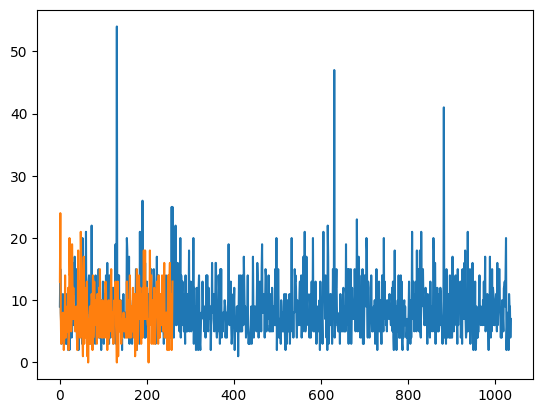

In [158]:
t=[]
r=[]
for i in x_train:
    t.append(len(i))
for i in x_val:
    r.append(len(i))
print(max(r))
print(max(t))
plt.plot(t)
plt.plot(r)
plt.show()

* 문장별 토큰이 가장 큰 것이 57개 입니다. 

* 학습 입력을 위한 데이터 크기 맞추기
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

In [48]:
x_train_pad = pad_sequences(x_train,maxlen=40)
x_val_pad = pad_sequences(x_val,maxlen=40)

In [49]:
x_train_pad

array([[  0,   0,   0, ...,   2,  19,  16],
       [  0,   0,   0, ...,   2,  19,  16],
       [  0,   0,   0, ...,  22,  12,   1],
       ...,
       [  0,   0,   0, ...,  11,   3,   1],
       [  0,   0,   0, ...,   4, 149,  16],
       [  0,   0,   0, ...,  13, 373, 198]], dtype=int32)

In [50]:
x_train_pad.shape,x_val_pad.shape

((1038, 40), (260, 40))

#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아 
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

In [51]:
keras.backend.clear_session()

il = Input(shape=(40,))
el = Embedding(1117,100,input_length=40)(il)
hl = LSTM(128,return_sequences=False)(el)
hl = keras.layers.BatchNormalization()(hl)
ol = keras.layers.Dense(1,activation="sigmoid")(hl)

model = keras.models.Model(il,ol)

model.compile(loss = keras.losses.binary_crossentropy,metrics=["accuracy"],optimizer="adam")

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding (Embedding)       (None, 40, 100)           111700    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 229,589
Trainable params: 229,333
Non-trainable params: 256
_____________________________________________________

In [52]:
es = EarlyStopping(monitor="val_loss",
                   patience=4,
                   min_delta=0,
                   verbose=1,
                   restore_best_weights=True)
model.fit(x_train_pad,train['type'],epochs=30,verbose=1,validation_data=(x_val_pad,test["type"]),callbacks=[es])

Epoch 1/30
33/33 [==============================] - 7s 121ms/step - loss: 0.1785 - accuracy: 0.9364 - val_loss: 0.5504 - val_accuracy: 0.7462
Epoch 2/30
33/33 [==============================] - 4s 111ms/step - loss: 0.0165 - accuracy: 0.9942 - val_loss: 0.4677 - val_accuracy: 0.9808
Epoch 3/30
33/33 [==============================] - 3s 77ms/step - loss: 0.0124 - accuracy: 0.9961 - val_loss: 0.4716 - val_accuracy: 0.7346
Epoch 4/30
33/33 [==============================] - 3s 80ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.3690 - val_accuracy: 0.9808
Epoch 5/30
33/33 [==============================] - 3s 81ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.2961 - val_accuracy: 1.0000
Epoch 6/30
33/33 [==============================] - 5s 142ms/step - loss: 5.7050e-04 - accuracy: 1.0000 - val_loss: 0.2401 - val_accuracy: 0.9962
Epoch 7/30
33/33 [==============================] - 3s 80ms/step - loss: 9.8079e-04 - accuracy: 1.0000 - val_loss: 0.2209 - val_accuracy: 0.9962
Ep

### (2) 사전학습모델(Word2Vec)

* Pre-trained Word2Vec model
    * 이미 다운로드 받아서 제공되었습니다.
        * ko.bin, ko.tsv
    * 참고 사이트: https://github.com/Kyubyong/wordvectors
        * 모델 파일 다운로드 사이트: https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view?resourcekey=0-Dq9yyzwZxAqT3J02qvnFwg
* 사전학습 모델을 로딩하고, 
* train 데이터셋의 질문(Q)을 임베딩벡터로 만들어, 열(Column)로 추가합니다.

#### 1) 모델 로딩
* 사전 학습된 모델을 로딩 : gensim.models.Word2Vec.load()
* 로딩 후 벡터 크기를 조회합시다. .vector_size

In [53]:
import gensim
pre_wv_model = gensim.models.Word2Vec.load(path + 'ko.bin')

In [54]:
# 모델의 벡터크기 조회
pre_wv_model.vector_size

200

#### 2) train 에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

In [55]:
xx = train["Q"].apply(lambda x:get_sent_embedding(pre_wv_model,200,x))
xx_ = train["Q"].apply(lambda x:get_sent_embedding(pre_wv_model,200,x.split(" ")))

In [56]:
p=[]
for i in xx:
    p.append(i)

xx=np.array(p)
np.array(xx).shape

(1038, 200)

In [57]:
p=[]
for i in xx_:
    p.append(i)

xx_=np.array(p)
np.array(xx_).shape

(1038, 200)

### (3) 챗봇 구축
* 아래 절차대로 수행하는 함수 만들기
    * input 질문 
    * 1단계 : 모델을 이용하여 type 0, 1로 분류
    * 2단계 : 
        * train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
        * 코사인 유사도가 가장 높은 Q를 선택
        * 선택한 Q의 intent에 맵핑된 답변 중 하나를 무작위로 선택

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

In [74]:
tok[0],train.iloc[0,2]

('서울 외 에 도 교육 장소 가 있 나요',
 'KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으로 운영합니다.\n오프라인 교육장소는 6개 권역(수도권, 강원권, 부산/경남권, 대구/경북권, 충남/충북권, 전남/전북권)에 위치하고 있습니다. \n\n서류 접수 마감 이후에 지원 지역(교육 장소) 변경은 불가능하며, 최종 합격된 지역에서만 교육이 가능합니다.')

* 예측을 위한 입력 형태로 변환
    * 학습을 위한 전처리 과정을 test 데이터에도 적용합니다. 

In [177]:
xx_train = token.texts_to_sequences([tok[0]])

In [178]:
xx_train

[[255, 129, 10, 15, 7, 96, 6, 3, 1]]

In [76]:
xx_train = pad_sequences(xx_train,maxlen=40)

In [78]:
get_sent_embedding(pre_wv_model,200,tok[0]).reshape(1,-1).shape

(1, 200)

In [169]:
xxx = test["Q"].apply(lambda x:get_sent_embedding(pre_wv_model,200,x))
xxx_ = test["Q"].apply(lambda x:get_sent_embedding(pre_wv_model,200,x.split(" ")))

In [ ]:
p=[]
for i in xxx:
    p.append(i)

xxx=np.array(p)
np.array(xxx).shape

(260, 200)

* 1단계 : type 분류

In [79]:
yy_pred = model.predict(xx_train)
if yy_pred>=0.5:
    print(1)
else:
    print(0)

1/1 [==============================] - 1s 513ms/step
1


* 2단계 : 질문에 대한 벡터 만들고 코사인 유사도 계산
    * Word2Vec 사전 학습 모델로 부터 벡터 만들기

In [80]:
xx_train_ = get_sent_embedding(pre_wv_model,200,tok[0]).reshape(1,-1)
xx_train_

array([[ 0.17993227, -0.4333763 ,  0.51966166,  0.36891493, -0.16347732,
         0.19355465,  0.24326625,  0.34530142,  0.20159477,  0.1536996 ,
         0.5239448 , -0.03524711, -0.3005213 , -0.7742091 , -0.33879212,
        -0.17755836, -0.6297239 , -0.37617227,  0.21039326, -0.04809066,
        -0.1544733 , -0.27026036, -0.05573536, -0.21541336, -0.51503503,
        -0.59863   ,  0.929102  ,  0.8531619 ,  0.32622895, -0.45516688,
        -0.2718195 , -0.43401787, -0.47768104,  0.53964114, -0.00753358,
         0.53582436, -0.01810679,  0.23605436, -0.33827865,  0.06622104,
        -0.33021876,  0.43221754,  0.36200497, -0.95679677,  0.34851906,
        -0.27808464, -0.43835062, -0.6770858 ,  0.5478206 ,  0.56614584,
         0.21903192, -0.6618363 ,  0.04145254,  0.45252144,  0.48091716,
         0.2612898 , -0.10096397,  0.7828683 ,  0.45805275,  0.28225294,
        -0.29753563, -1.1154752 , -0.19339402, -0.4470615 , -0.18304978,
         0.14128102,  0.162936  , -0.62746274,  0.1

* train의 질문 벡터들과 유사도 계산
    * Word2Vec 으로 만든 벡터들과 유사도 계산

In [81]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(xx, xx_train_)
result = []
for i in cosine_similarity(xx, xx_train_):
    result.append(i)
result.index(max(result))
cosine_similarity(xx, xx_train_)[result.index(max(result))]
xx[0].reshape(1,-1).shape

(1, 200)

In [82]:
train.iloc[result.index(max(result))]["intent"]

43

#### 2) 챗봇 함수 만들기
* 위 테스트 결과를 바탕으로 코드를 정리하고 함수로 생성합니다.

In [58]:
def get_answer2(question):
    text = tokenize("mecab",question) 
    a=token.texts_to_sequences([text])
    # print(a)
    a = pad_sequences(a,maxlen=40)
    # print(a)
    b=model.predict(a)
    if b>=0.5:
        b=1
    else:
        b=0
    c = get_sent_embedding(pre_wv_model,200,text).reshape(1,-1)
    result = []
    for i in cosine_similarity(xx, c):
        result.append(i)
    # print(len(result))
    # print(result.index(max(result)))
    d = train.iloc[result.index(max(result))]["intent"]
    # print(b,d)
    e = train[(train["intent"]==d) & (train["type"]==b)]["A"].index
    e1 = train[(train["intent"]==d)]["A"].index
    if len(e)==0:
        random_element = random.choice(list(e1))
        return train[(train["intent"]==d)]["A"][random_element],d
    else:
        random_element = random.choice(list(e))
        return train[(train["intent"]==d) & (train["type"]==b)]["A"][random_element],d

In [59]:
get_answer2("배고파")

1/1 [==============================] - 0s 494ms/step


('많이 지쳤나봐요.', 7)

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [60]:
u=[]
for i in test["Q"]:
    u.append(get_answer2(i)[1])
    # print(get_answer2(i)[1])
u = np.array(u)
accuracy_score(test["intent"],u)

1/1 [==============================] - 0s 35ms/step


0.7192307692307692

## 4.챗봇3

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : 챗봇2의 1단계 모델을 사용합니다.
        * 2단계 : 
            * 각 type에 맞게, 사전학습된 Word2Vec 모델을 사용하여 임베딩 벡터(train)를 만들고
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링
- LSTM : 3-(1) 모델을 그대로 사용합니다.

### (2) FastText 모델

-  FastText 모델 학습을 위한 입력 포맷 2차원 리스트 형태 입니다.
  ```
  [['나', '는', '학생', '이다'], ['오늘', '은', '날씨', '가', '좋다']]
  ```

- Word2Vec계열의 FastText를 학습하는 이유
  - n-gram이 추가된 fasttext 모델은 유사한 단어에 대한 임베딩을 word2vec보다 잘 해결할 수 있으며, 오탈자 등에 대한 임베딩 처리가 가능하다.
  - 예) 체크카드, 쳌카드는 word2vec에서는 전혀 다른 단어이지만 fasttext는 character n-gram으로 비교적 같은 단어로 처리할 수 있다.
- 참고: https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText


#### 1) 데이터 준비
* 시작데이터 : clean_train_questions, clean_test_questions

* FastText를 위한 입력 데이터 구조 만들기

In [61]:
aa = []
for i in clean_train_questions:
    aa.append(i.split(" "))
aa

[['다른', '지역', '에서', '도', '교육', '이', '가능', '한가요'],
 ['합격',
  '후',
  '교육',
  '등록',
  '신청',
  '을',
  '하',
  '지',
  '않',
  '으면',
  '재',
  '지원',
  '이',
  '가능',
  '한가요'],
 ['대학원생', '서류', '가', '어떻게', '되', '나요'],
 ['재밌', '는', '거', '뭐', '없', '나'],
 ['생각', '보다', '오늘', '너무', '춥', '네'],
 ['KT', '채용', '연계', '시', '중점', '적', '으로', '보', '는', '요소', '가', '있', '나요'],
 ['드디어', '천일'],
 ['수업', '외', '에', '시험', '이나', '과제', '가', '있', '나요'],
 ['지원', '자격', '에', '대해서', '알려', '주', '세요'],
 ['미취', '업자', '에', '대한', '기준', '은', '어떻게', '판단', '하', '나요'],
 ['바다', '가', '자', '고', '하', '면', '갈까'],
 ['실업', '급여', '수령', '중', '에', '도', '교육', '을', '들', '을', '수', '있', '나요'],
 ['코', '막혀'],
 ['수업', '만', '들으면', '되', '나요'],
 ['노트북', '안', '돼'],
 ['목걸이', '선물', '이', '좋', '겠', '다'],
 ['서류', '접수', '시', '작성', '한', '지역', '에서', '만', '교육', '이', '가능', '한가요'],
 ['재밌', '는', '일', '이', '없', '어'],
 ['감기', '걸렸', '나', '봐'],
 ['바나나', '먹', '어야지'],
 ['35', '세', '는', '지원', '할', '수', '없', '나요'],
 ['전공', '에', '대한', '기초', '가', '없', '는', '데', '괜찮', '나요'],
 ['

In [ ]:
#tok
#tok_test

**굵은 텍스트**#### 2) FastText 모델 생성
* FastText 문법
    * FastText( input데이터,  min_count = , size= , window=  )
        * input데이터 : 학습에 사용할 문장으로 이루어진 리스트
        * min_count : 모델에 사용할 단어의 최소 빈도수. 이 값보다 적게 출현한 단어는 모델에 포함되지 않음. 기본값 = 5
        * size : 단어의 벡터 차원 지정. 기본값 = 100
        * window : 학습할 때 한 단어의 좌우 몇 개의 단어를 보고 예측을 할 것인지를 지정. 기본값 = 5
    * 참조 : https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText

In [88]:
from gensim.models.fasttext import FastText
import gensim.models.word2vec
fast_model = FastText(aa,size=200,min_count=1)


In [63]:
fast_model.vector_size

200

#### 3) train에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

In [162]:
train["Q"].apply(lambda x:x.split(" "))

469                [서울, 외에도, 교육, 장소가, 있나요]
56     [고용보험에, 가입되어, 있지만, 않으면, 미취업자로, 보나요]
783                 [다른, 국비지원과, 차이점이, 있나요]
336                         [회식, 했으면, 좋겠다]
185                             [우울증, 생겼어]
                      ...                 
771       [대면, 교육, 때, 머무를, 수, 있는, 곳이, 있나요]
229                [결과발표, 이후에, 추가합격이, 있나요]
443               [교육, 수료, 시, 출석율이, 반영되나요]
405                             [번호, 따볼까나]
134                   [프리랜서도, 신청할, 수, 있나요]
Name: Q, Length: 1038, dtype: object

In [89]:
xxx = train["Q"].apply(lambda x:get_sent_embedding(fast_model,200,x))
xxx_ = train["Q"].apply(lambda x:get_sent_embedding(fast_model,200,x.split(" ")))

In [90]:
p=[]
for i in xxx:
    p.append(i)

xxx=np.array(p)
np.array(xxx).shape

(1038, 200)

In [91]:
p=[]
for i in xxx_:
    p.append(i)

xxx_=np.array(p)
np.array(xxx_).shape

(1038, 200)

### (3) 챗봇 구축
- input 질문
- intent classifier로 common와 faq 중 하나를 예측
- 예측된 intent에 속한 train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
- 코사인 유사도가 가장 높은 top-3개의 Q를 선택
- 선택한 Q에 맵핑된 답변 중 하나를 선택하고 실제 답변과 비교

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

In [ ]:
tok[0],train.iloc[0,2]

('서울 외 에 도 교육 장소 가 있 나요',
 'KT 에이블스쿨은 전국 어디서나 참여할 수 있도록, 온/오프라인을 병행하여 탄력적으로 운영합니다.\n오프라인 교육장소는 6개 권역(수도권, 강원권, 부산/경남권, 대구/경북권, 충남/충북권, 전남/전북권)에 위치하고 있습니다. \n\n서류 접수 마감 이후에 지원 지역(교육 장소) 변경은 불가능하며, 최종 합격된 지역에서만 교육이 가능합니다.')

* 예측을 위한 입력 형태로 변환

In [ ]:
xxx_train = token.texts_to_sequences([tok[0]])
xxx_train = pad_sequences(xxx_train,maxlen=40)

* 예측하기

In [ ]:
model.predict(xxx_train)

1/1 [==============================] - 0s 70ms/step


array([[0.9973272]], dtype=float32)

* 질문에 대한 벡터 만들기
    * FestText 모델로 부터 벡터 만들기

In [121]:
tok[0].split(" ")

['서울', '외', '에', '도', '교육', '장소', '가', '있', '나요']

In [122]:
xxx_train_ = get_sent_embedding(fast_model,200,tok[0].split(" ")).reshape(1,-1)

In [124]:
xxx_train_.shape

(1, 200)

* train의 질문 벡터들과 유사도 계산
    * FastText 로 만들 벡터들과 유사도 계산

In [125]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(xxx,xxx_train_)
result = []
for i in cosine_similarity(xxx,xxx_train_):
    result.append(i)
result.index(max(result))
cosine_similarity(xxx, xxx_train_)[result.index(max(result))]
xxx[result.index(max(result))].reshape(1,-1).shape

(1, 200)

In [ ]:
print(result.index(max(result)))

0



#### 2) 함수로 생성하기

In [92]:
def get_answer3(question): 
    text = tokenize("mecab",question) 
    a=token.texts_to_sequences([text])
    # print(a)
    a = pad_sequences(a,maxlen=40)
    # print(a)
    b=model.predict(a)
    if b>=0.5:
        b=1
    else:
        b=0
    # print(text.split(" "))
    c = get_sent_embedding(fast_model,200,text).reshape(1,-1)
    result = []
    for i in cosine_similarity(xxx, c):
        result.append(i)
    d = train.iloc[result.index(max(result))]["intent"]
    # print(b,d)
    e = train[(train["intent"]==d) & (train["type"]==b)]["A"].index
    e1 = train[(train["intent"]==d)]["A"].index
    if len(e)<=0:
        random_element = random.choice(list(e1))
        return train[(train["intent"]==d)]["A"][random_element],d
    else:
        random_element = random.choice(list(e))
        return train[(train["intent"]==d) & (train["type"]==b)]["A"][random_element],d

In [93]:
get_answer3("이제 나도 성인이야")

1/1 [==============================] - 0s 36ms/step


('기분 좋겠어요.', 29)

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [94]:
u=[]
for i in test["Q"]:
    u.append(get_answer3(i)[1])
    # print(get_answer2(i)[1])
u = np.array(u)
accuracy_score(test["intent"],u)

1/1 [==============================] - 0s 34ms/step


0.6269230769230769

## 5.질문에 대한 답변 비교해보기

* **세부요구사항**
    * 세가지 챗봇을 생성해 보았습니다. 
    * 질문을 입력하여 답변을 비교해 봅시다. 어떤 챗봇이 좀 더 정확한 답변을 하나요?
